### 빅쿼리 연동

In [1]:
#bigquery 연동하기 
from google.oauth2 import service_account
from google.cloud import bigquery

In [2]:
credentials = service_account.Credentials.from_service_account_file('./jsonkey.json')

In [3]:
credentials

In [4]:
client = bigquery.Client(
    credentials=credentials,
    project=credentials.project_id
)

In [5]:
client

In [6]:
import pandas as pd

In [18]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'

In [8]:
pd.set_option('display.max_rows', None)  # 모든 행 표시
pd.set_option('display.max_columns', None)  # 모든 열 표시
pd.set_option('display.expand_frame_repr', False)  # 열이 화면 너비를 초과할 때 데이터프레임을 줄 바꿈하지 않도록 설정

### 서울시 자치구별 따릉이 사용량

In [9]:
query = """
SELECT 
  REGEXP_EXTRACT(Address_1, r'([가-힣]+구)') AS district,  -- 구 이름 추출
  COUNT(*) AS usage_count  -- 사용량 계산
FROM 
  `multi-final-project.Rental_usage_history.Rental_usage_history_*` AS A
JOIN 
  `multi-final-project.Rental_Location_ID_master.Rental_Location_ID_master_la_lo` AS B
ON 
  A.Rental_Location_ID = B.Rental_Location_ID
  WHERE _TABLE_SUFFIX BETWEEN '2301' AND '2312'
  AND NOT REGEXP_CONTAINS(B.Address_1, r'경기도')

GROUP BY
  district
ORDER BY
  usage_count DESC
"""

In [10]:
test_df = client.query(query).to_dataframe()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [11]:
test_df

,district,usage_count
0,강서구,5392924
1,송파구,4132739
2,영등포구,3849246
3,노원구,2809646
4,양천구,2698516
5,마포구,2278690
6,광진구,2250705
7,강동구,1991724
8,구로구,1877199
9,성동구,1780862


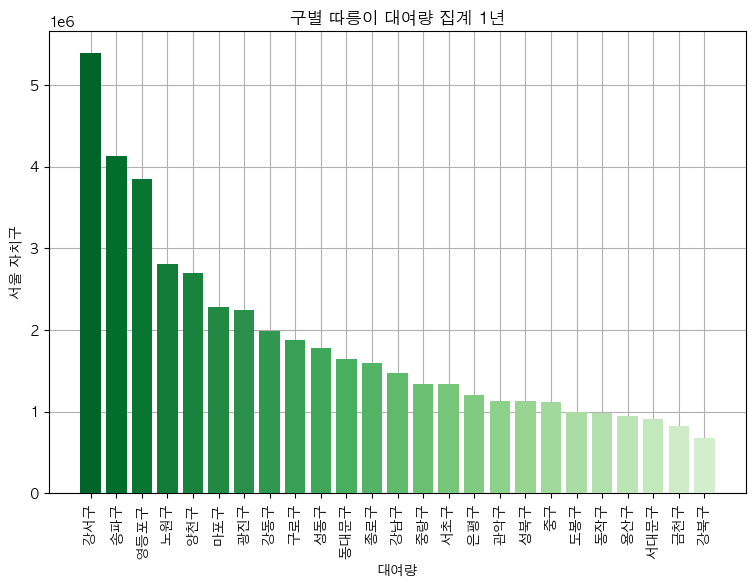

In [64]:
import numpy as np
import matplotlib.cm as cm

plt.figure(figsize=(9, 6))
n = len(test_df)
cmap = plt.get_cmap('Greens')
colors = cmap(np.linspace(0.9, 0.2, n))
plt.bar(test_df['district'],test_df['usage_count'],zorder = 3, color = colors)

plt.xticks(rotation=90)
plt.title('구별 따릉이 대여량 집계 1년')
plt.xlabel('대여량')
plt.ylabel('서울 자치구')
plt.xticks(rotation=90)
plt.grid(True, zorder=0)

plt.show()

### 자치구별 이동량 집계

In [23]:
query = """
SELECT 
  REGEXP_EXTRACT(B_rent.Address_1, r'([가-힣]+구)') AS rental_district,  -- 대여 위치 구 이름
  REGEXP_EXTRACT(B_return.Address_1, r'([가-힣]+구)') AS return_district,  -- 반납 위치 구 이름
  COUNT(*) AS move_count  -- 이동 횟수
FROM 
  `multi-final-project.Rental_usage_history.Rental_usage_history_*` AS A
JOIN 
  `multi-final-project.Rental_Location_ID_master.Rental_Location_ID_master_la_lo` AS B_rent
ON 
  A.Rental_Location_ID = B_rent.Rental_Location_ID  -- 대여 위치

JOIN 
  `multi-final-project.Rental_Location_ID_master.Rental_Location_ID_master_la_lo` AS B_return
ON 
  A.Return_Location_ID = B_return.Rental_Location_ID  -- 반납 위치
WHERE 
  _TABLE_SUFFIX BETWEEN '2301' AND '2312'
  AND NOT REGEXP_CONTAINS(B_rent.Address_1, r'경기도')  -- 경기도 대여 위치 제외
  AND NOT REGEXP_CONTAINS(B_return.Address_1, r'경기도')  -- 경기도 반납 위치 제외
GROUP BY
  rental_district, return_district  -- 대여 구와 반납 구별 그룹화
ORDER BY 
  move_count DESC  -- 이동이 많은 순서로 정렬
LIMIT 1000;
"""

In [24]:
move_gu_df = client.query(query).to_dataframe()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


### 따릉이 부족 자치구

In [9]:
query = """
WITH rental_counts AS (
  -- 각 구에서 대여된 대수 집계
  SELECT 
    REGEXP_EXTRACT(B_rent.Address_1, r'([가-힣]+구)') AS district,  -- 대여 구 추출
    COUNT(*) AS rental_count  -- 대여 횟수 집계
  FROM 
    `multi-final-project.Rental_usage_history.Rental_usage_history_*` AS A
  JOIN 
    `multi-final-project.Rental_Location_ID_master.Rental_Location_ID_master_la_lo` AS B_rent
  ON 
    A.Rental_Location_ID = B_rent.Rental_Location_ID  -- 대여 위치
  WHERE 
    _TABLE_SUFFIX BETWEEN '2301' AND '2312'
    AND NOT REGEXP_CONTAINS(B_rent.Address_1, r'경기도')  -- 경기도 제외
  GROUP BY 
    district
),
return_counts AS (
  -- 각 구에서 반납된 대수 집계
  SELECT 
    REGEXP_EXTRACT(B_return.Address_1, r'([가-힣]+구)') AS district,  -- 반납 구 추출
    COUNT(*) AS return_count  -- 반납 횟수 집계
  FROM 
    `multi-final-project.Rental_usage_history.Rental_usage_history_*` AS A
  JOIN 
    `multi-final-project.Rental_Location_ID_master.Rental_Location_ID_master_la_lo` AS B_return
  ON 
    A.Return_Location_ID = B_return.Rental_Location_ID  -- 반납 위치
  WHERE 
    _TABLE_SUFFIX BETWEEN '2301' AND '2312'
    AND NOT REGEXP_CONTAINS(B_return.Address_1, r'경기도')  -- 경기도 제외
  GROUP BY 
    district
)
-- 두 집계 결과를 결합하여 대여와 반납 차이 계산
SELECT 
  COALESCE(rental_counts.district, return_counts.district) AS district,  -- 구 이름
  COALESCE(rental_count, 0) AS rental_count,  -- 대여 대수
  COALESCE(return_count, 0) AS return_count,  -- 반납 대수
  (COALESCE(return_count, 0) - COALESCE(rental_count, 0)) AS count_difference  -- 반납 - 대여 차이
FROM 
  rental_counts
FULL OUTER JOIN 
  return_counts
ON 
  rental_counts.district = return_counts.district
-- 반납 대수가 대여 대수보다 적은 지역만 필터링
WHERE 
  (COALESCE(return_count, 0) - COALESCE(rental_count, 0)) < 0
ORDER BY 
  count_difference ASC
LIMIT 100;
"""

In [10]:
df = client.query(query).to_dataframe()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [12]:
df.head()

,district,rental_count,return_count,count_difference
0,강남구,1471869,1398406,-73463
1,종로구,1592235,1524401,-67834
2,중구,1113109,1056691,-56418
3,영등포구,3849246,3808360,-40886
4,서대문구,911273,875724,-35549


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


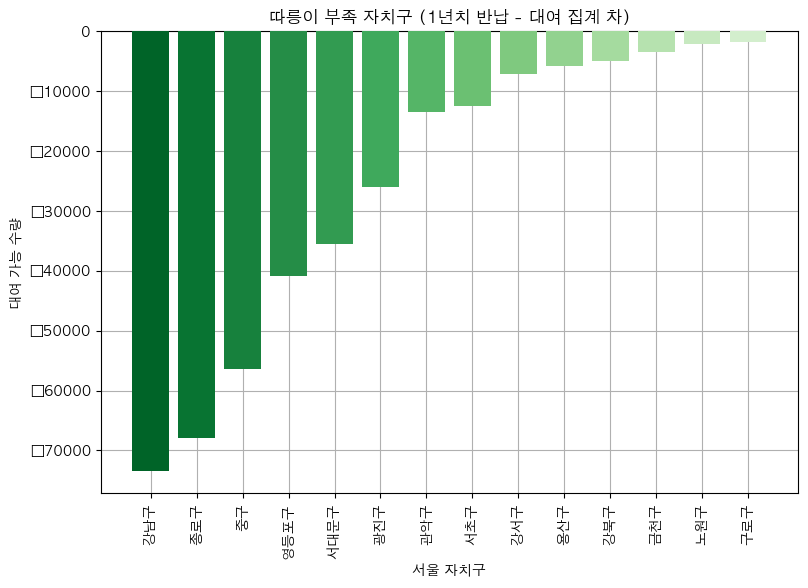

In [24]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.ticker as ticker

plt.figure(figsize=(9, 6))
n = len(df)
cmap = plt.get_cmap('Greens')
colors = cmap(np.linspace(0.9, 0.2, n))
plt.bar(df['district'],df['count_difference'],zorder = 3, color = colors)
# 음수 기호 유니코드 설정
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}".replace("-", "\u2212")))
plt.xticks(rotation=90)
plt.title('따릉이 부족 자치구 (1년치 반납 - 대여 집계 차)')
plt.xlabel('서울 자치구')
plt.ylabel('대여 가능 수량')
plt.xticks(rotation=90)
plt.grid(True, zorder=0)

plt.show()

### 강남구 월별 부족량 집계

In [31]:
gangnamgu_month_query = """
WITH rental_counts AS (
  -- 각 구와 월별로 대여된 대수 집계
  SELECT 
    FORMAT_DATE('%Y-%m', DATE(A.Date_and_time_of_rental)) AS MONTH,  -- 월 단위로 포맷팅
    REGEXP_EXTRACT(B_rent.Address_1, r'([가-힣]+구)') AS district,  -- 대여 구 추출
    COUNT(*) AS rental_count  -- 대여 횟수 집계
  FROM 
    `multi-final-project.Rental_usage_history.Rental_usage_history_*` AS A
  JOIN 
    `multi-final-project.Rental_Location_ID_master.Rental_Location_ID_master_la_lo` AS B_rent
  ON 
    A.Rental_Location_ID = B_rent.Rental_Location_ID  -- 대여 위치
  WHERE 
    _TABLE_SUFFIX BETWEEN '2301' AND '2312'
    AND NOT REGEXP_CONTAINS(B_rent.Address_1, r'경기도')  -- 경기도 제외
  GROUP BY 
    district, MONTH  -- 구와 월로 그룹화
),
return_counts AS (
  -- 각 구와 월별로 반납된 대수 집계
  SELECT
    FORMAT_DATE('%Y-%m', DATE(A.Return_date)) AS MONTH,  -- 월 단위로 포맷팅
    REGEXP_EXTRACT(B_return.Address_1, r'([가-힣]+구)') AS district,  -- 반납 구 추출
    COUNT(*) AS return_count  -- 반납 횟수 집계
  FROM 
    `multi-final-project.Rental_usage_history.Rental_usage_history_*` AS A
  JOIN 
    `multi-final-project.Rental_Location_ID_master.Rental_Location_ID_master_la_lo` AS B_return
  ON 
    A.Return_Location_ID = B_return.Rental_Location_ID  -- 반납 위치
  WHERE 
    _TABLE_SUFFIX BETWEEN '2301' AND '2312'
    AND NOT REGEXP_CONTAINS(B_return.Address_1, r'경기도')  -- 경기도 제외
  GROUP BY 
    district, MONTH  -- 구와 월로 그룹화
)
-- 두 집계 결과를 결합하여 대여와 반납 차이 계산
SELECT
  COALESCE(rental_counts.MONTH, return_counts.MONTH) AS MONTH,  -- 월
  COALESCE(rental_counts.district, return_counts.district) AS district,  -- 구 이름
  COALESCE(rental_count, 0) AS rental_count,  -- 대여 대수
  COALESCE(return_count, 0) AS return_count,  -- 반납 대수
  (COALESCE(return_count, 0) - COALESCE(rental_count, 0)) AS count_difference  -- 반납 - 대여 차이
FROM 
  rental_counts
FULL OUTER JOIN 
  return_counts
ON 
  rental_counts.district = return_counts.district
  AND rental_counts.MONTH = return_counts.MONTH  -- 월과 구를 기준으로 결합
WHERE 
  (COALESCE(return_count, 0) - COALESCE(rental_count, 0)) < 0  -- 반납 대수가 대여 대수보다 적은 경우만 필터링
  AND COALESCE(rental_counts.district, return_counts.district) = '강남구'
ORDER BY 
  MONTH ASC  -- 차이가 큰 순서대로 정렬
LIMIT 100;
"""

In [32]:
gangnamgu_month_df = client.query(gangnamgu_month_query).to_dataframe()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [38]:
gangnamgu_month_df.describe()

,rental_count,return_count,count_difference
count,12.0,12.0,12.0
mean,122655.75,116532.833333,-6122.916667
std,41513.418234,38964.255575,2628.637755
min,48272.0,46404.0,-9261.0
25%,106161.75,101750.75,-8119.25
50%,126105.5,119469.0,-6752.0
75%,152743.75,144610.0,-4411.0
max,182304.0,173295.0,-1868.0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


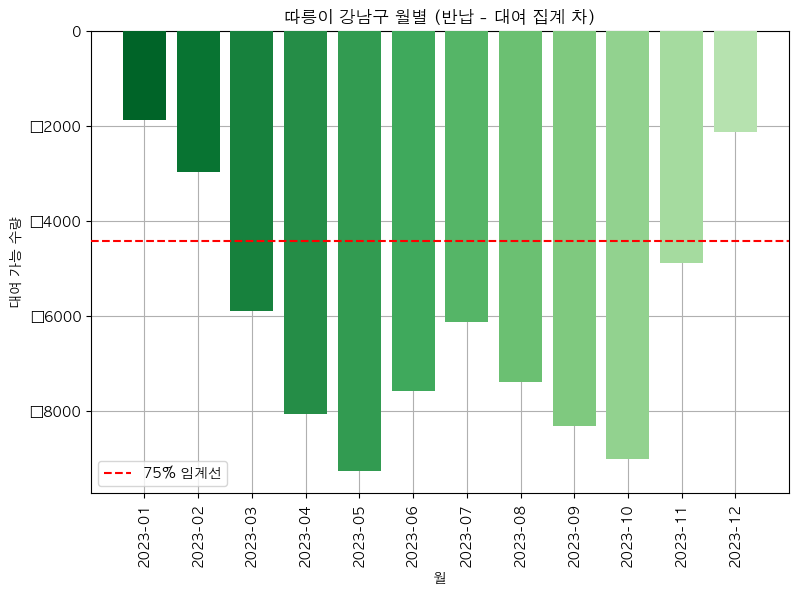

In [49]:
import matplotlib.cm as cm
import matplotlib.ticker as ticker

plt.figure(figsize=(9, 6))
n = len(df)
cmap = plt.get_cmap('Greens')
colors = cmap(np.linspace(0.9, 0.2, n))
plt.bar(gangnamgu_month_df['MONTH'],gangnamgu_month_df['count_difference'],zorder = 3, color = colors)
plt.xticks(rotation=90)
plt.title('따릉이 강남구 월별 (반납 - 대여 집계 차)')
plt.axhline(y=-4411, color='r', linestyle='--', label='75% 임계선',zorder = 4)
plt.xlabel('월')
plt.ylabel('대여 가능 수량')
plt.xticks(rotation=90)
plt.grid(True, zorder=0)
# 레전드 추가 (gca().legend() 사용)
plt.gca().legend()

plt.show()

### 강남구, 종로구, 중구 월별 계절성확인

In [82]:
query = """
WITH rental_counts AS (
  -- 각 구와 일별로 대여된 대수 집계
  SELECT 
    DATE(A.Date_and_time_of_rental) AS DAY,  -- 일 단위로 포맷팅
    EXTRACT(HOUR FROM A.Date_and_time_of_rental) AS hour,  -- 시간대 추출
    REGEXP_EXTRACT(B_rent.Address_1, r'([가-힣]+구)') AS district,  -- 대여 구 추출
    B_rent.Rental_location_ID,  -- 대여 장소 ID
    COUNT(*) AS rental_count  -- 대여 횟수 집계
  FROM 
    `multi-final-project.Rental_usage_history.Rental_usage_history_2305` AS A
  JOIN 
    `multi-final-project.Rental_Location_ID_master.Rental_Location_ID_master_la_lo` AS B_rent
  ON 
    A.Rental_Location_ID = B_rent.Rental_Location_ID  -- 대여 위치
  WHERE 
    NOT REGEXP_CONTAINS(B_rent.Address_1, r'경기도')  -- 경기도 제외
    AND REGEXP_CONTAINS(B_rent.Address_1, r'강남구')  -- 강남구만 불러오기
  GROUP BY 
    district, DAY, hour, B_rent.Rental_location_ID  -- 구, 일, 시간대, 대여 장소 ID로 그룹화
),
return_counts AS (
  -- 월별로 반납된 대수 집계
  SELECT
    DATE(A.Date_and_time_of_rental) AS DAY,  -- 일 단위로 포맷팅
    EXTRACT(HOUR FROM A.Date_and_time_of_rental) AS hour,  -- 시간대 추출
    REGEXP_EXTRACT(B_return.Address_1, r'([가-힣]+구)') AS district,  -- 반납 구 추출
    B_return.Rental_location_ID,  -- 반납 장소 ID
    COUNT(*) AS return_count  -- 반납 횟수 집계
  FROM 
    `multi-final-project.Rental_usage_history.Rental_usage_history_2305` AS A
  JOIN 
    `multi-final-project.Rental_Location_ID_master.Rental_Location_ID_master_la_lo` AS B_return
  ON 
    A.Return_Location_ID = B_return.Rental_Location_ID  -- 반납 위치
  WHERE 
    NOT REGEXP_CONTAINS(B_return.Address_1, r'경기도')  -- 경기도 제외
    AND REGEXP_CONTAINS(B_return.Address_1, r'강남구')  -- 강남구만 불러오기
  GROUP BY 
    district, DAY, hour, B_return.Rental_location_ID  -- 구, 일, 시간대, 반납 장소 ID로 그룹화
)
-- 두 집계 결과를 결합하여 대여와 반납 차이 계산
SELECT
  COALESCE(rental_counts.Rental_location_ID, return_counts.Rental_location_ID) AS Rental_location_ID,  -- 대여/반납 장소 ID
  COALESCE(rental_counts.DAY, return_counts.DAY) AS DAY,  -- 날짜
  COALESCE(rental_counts.hour, return_counts.hour) AS hour,  -- 시간대
  COALESCE(rental_counts.district, return_counts.district) AS district,  -- 구 이름
  COALESCE(rental_count, 0) AS rental_count,  -- 대여 대수
  COALESCE(return_count, 0) AS return_count,  -- 반납 대수
  (COALESCE(return_count, 0) - COALESCE(rental_count, 0)) AS count_difference  -- 반납 - 대여 차이
FROM 
  rental_counts
FULL OUTER JOIN 
  return_counts
ON 
  rental_counts.district = return_counts.district
  AND rental_counts.DAY = return_counts.DAY
  AND rental_counts.hour = return_counts.hour
  AND rental_counts.Rental_location_ID = return_counts.Rental_location_ID  -- 일, 시간대, 장소 ID를 기준으로 결합
ORDER BY 
  DAY, hour ASC  -- 일과 시간대 순서대로 정렬
LIMIT 1000;
"""

In [83]:
month_gu_df = client.query(query).to_dataframe()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [84]:
month_gu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Rental_location_ID  1000 non-null   object
 1   DAY                 1000 non-null   dbdate
 2   hour                1000 non-null   Int64 
 3   district            1000 non-null   object
 4   rental_count        1000 non-null   Int64 
 5   return_count        1000 non-null   Int64 
 6   count_difference    1000 non-null   Int64 
dtypes: Int64(4), dbdate(1), object(2)
memory usage: 58.7+ KB


In [85]:
unique_values = month_gu_df['Rental_location_ID'].unique()

In [87]:
count_unique_values = len(unique_values)

In [88]:
count_unique_values

166

In [80]:
month_gu_df.set_index("district", inplace=True)

In [81]:
month_gu_df

,MONTH,rental_count,return_count,count_difference
district,,,,
강남구,2023-05,164493,155262,-9231
강남구,2023-10,182304,173300,-9004
종로구,2023-05,174589,165655,-8934
강남구,2023-09,151515,143188,-8327
종로구,2023-06,166090,157779,-8311
강남구,2023-04,139836,131760,-8076
강남구,2023-06,156430,148845,-7585
종로구,2023-10,182013,174605,-7408
강남구,2023-08,129221,121847,-7374
